Data source: https://covid.ourworldindata.org/data/owid-covid-data.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
df = pd.read_csv("owid-covid-data.csv")
df = df.set_index("location")

#Change location here!
mal_df = df.loc["Malaysia"]

start_date = datetime.strptime(mal_df.iloc[0]["date"], "%Y-%m-%d")
print("Note: Date starting from: ", start_date)
for i in range(len(mal_df["date"])):
    temp = datetime.strptime(mal_df.iloc[i]["date"], "%Y-%m-%d") - start_date
    mal_df["date"].iloc[i] = int(temp.days)
    
print(mal_df)

Note: Date starting from:  2019-12-31 00:00:00
         iso_code  date  total_cases  new_cases  total_deaths  new_deaths  \
location                                                                    
Malaysia      MYS     0            0          0             0           0   
Malaysia      MYS     1            0          0             0           0   
Malaysia      MYS     2            0          0             0           0   
Malaysia      MYS     3            0          0             0           0   
Malaysia      MYS     4            0          0             0           0   
...           ...   ...          ...        ...           ...         ...   
Malaysia      MYS   134         6742         16           109           0   
Malaysia      MYS   135         6779         37           111           2   
Malaysia      MYS   136         6819         40           112           1   
Malaysia      MYS   137         6855         36           112           0   
Malaysia      MYS   138      

/Users/adamloi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/adamloi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


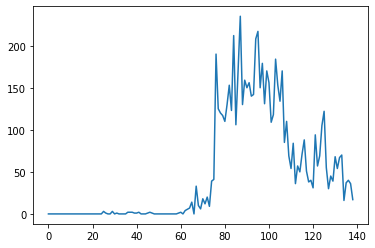

In [3]:
#Change to any data you like!
fig, ax = plt.subplots()
xdata = mal_df["date"]
ydata = mal_df["new_cases"]
ax.plot(xdata, ydata)
plt.show()

In [4]:
#from QR:
def QR_decompose(A):
    M = A.copy()
    Q = []
    R = []
    for i in range(len(M)):
        #get normalised q vector
        temp = M[i]
        for qi in Q:
            temp -= temp.dot(qi)*qi
        Q.append(temp/(np.sqrt(sum(temp**2))))
        #get r value by dot product
        temp_r = []
        for j in range(len(M)):
            temp_r.append(np.array(Q[i]).dot(M[j]))
        R.append(temp_r)
    Q = np.array(Q)
    R = np.array(R).transpose()
    return Q, R

def get_best_fit(Q, R, y):
    x = np.zeros(len(R))
    temp = y.dot(Q.transpose())
    for i in reversed(range(len(R))):
        temp_x = temp[i]
        for j in reversed(range(i, len(R))):
            if i != j:
                temp_x -= R[j, i]*x[j]
        x[i] = temp_x/R[i][i]           
    return x

#NEW!
def polyfit(xdata, ydata, n):
    N = len(xdata)
    A = []
    for i in range(n):
        if i==0:
            A.append(np.ones(N))
        else:
            A.append(xdata**i)
    A = np.array(A)
    Q, R = QR_decompose(A)
    xfit = get_best_fit(Q, R, ydata)
    yfit = xfit.dot(A)
    return yfit

In [5]:
xdata = np.array(xdata)
ydata = np.array(ydata)
n = 5
yfit = polyfit(xdata, ydata, n)

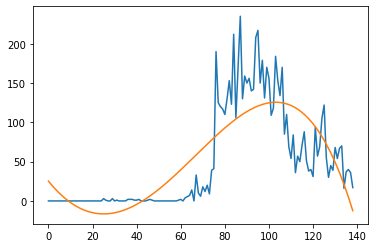

In [6]:
fig, ax = plt.subplots()
ax.plot(xdata, ydata)
ax.plot(xdata, yfit)
plt.show()

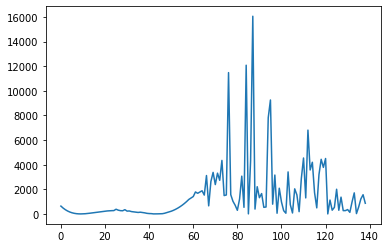

In [7]:
#Residuals
resi = (yfit - ydata)**2
plt.plot(xdata, resi)
plt.show()

In [8]:
#Passing through a low pass filter hmm?
#From DFT:
def DFT(fdata):
    N = len(fdata)
    j = complex(0, 1)
    Fdata = []
    for k in range(N):
        temp = 0
        for f, n in zip(fdata, range(N)):
            temp += f*np.e**(-j*2*np.pi*n*k/N)
        Fdata.append(temp)
    return Fdata
        
def IDFT(Fdata):
    N = len(Fdata)
    j = complex(0, 1)
    fdata = []
    for n in range(N):
        temp = 0
        for F, k in zip(Fdata, range(N)):
            temp += (1/N)*F*np.e**(j*2*np.pi*n*k/N)
        fdata.append(temp)
    return fdata

/Users/adamloi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


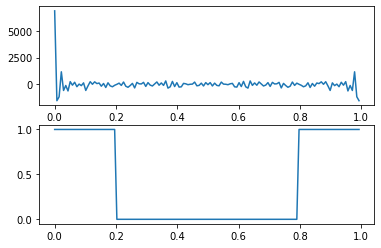

In [9]:
Fdata = DFT(ydata)
df = 1/(len(xdata)*(xdata[2]-xdata[1]))
f = np.array(range(len(xdata)))*df

B = 0.2
H = np.zeros(len(f))
for i in range(len(f)):
    if f[i] < B or f[i] > f.max()-B:
        H[i] = 1
        
fig, ax = plt.subplots(2, 1)
ax[0].plot(f, Fdata)
ax[1].plot(f, H)
plt.show()

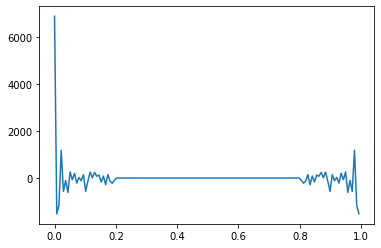

In [10]:
plt.plot(f, Fdata*H)
plt.show()

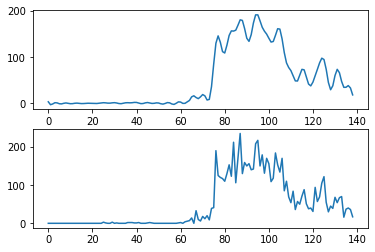

In [11]:
ysmooth = IDFT(Fdata*H)
fig, ax = plt.subplots(2, 1)
ax[0].plot(xdata, ysmooth)
ax[1].plot(xdata, ydata)
plt.show()